**Table of contents**<a id='toc0_'></a>    
- [Importación de librerías](#toc1_)    
- [Importación del archivo JSON](#toc2_)    
- [Creamos los DataFramees](#toc3_)    
- [Estación con mayor número de registros](#toc4_)    
- [Gráficas](#toc5_)    
- [Creación del dataframe tb_ , donde operamos para hacer los modelos de Predicción](#toc6_)    
- [Comparación de Gráficas de los Contaminantes](#toc7_)    
- [Empiezo con el Modelo de Support Vector Machine](#toc8_)    
- [Usamos GridSearch para optimizar los hiperparámetros y ver si mejora nuestro modelo](#toc9_)    
- [Creamos otro modelo llamado Red Neuronal para ver cuál es mejor para nuestros datos](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Importación de librerías](#toc0_)

In [1]:
import json
import numpy as np
import pandas as pd
from datetime import datetime

import time
import seaborn as sns
from sklearn import tree
from graphviz import Source
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score

import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV


# <a id='toc2_'></a>[Importación del archivo JSON](#toc0_)

In [2]:
# SE LEE LA BASE DE DATOS (CONTAMINANTES 2018)
f = open('contaminantes_2018.json')
db_contaminantes = json.load(f)
f.close()


# defino fondo negro 

plt.style.use('dark_background')

# <a id='toc3_'></a>[Creamos los DataFramees](#toc0_)

In [3]:
# SE CREA LA LISTA DE CONTAMINANTES
ls_contaminantes = list(db_contaminantes['pollutionMeasurements']['date']['2018-01-01 01:00'].keys())

# SE CREA LA LISTA DE ESTACIONES
ls_estaciones = list(db_contaminantes['pollutionMeasurements']['date']['2018-01-01 01:00']['O3'].keys())

# SE CREA EL ARRAY DE COLORES
colores = ['#0FFF95', '#D7263D', '#2A45CB', '#D62EBD', '#8884FF', '#6FE33D', '#D11C25', '#F1B127', '#FF0ACE']

# SE CREA LA TABLA DE CONTEOS VALIDOS
tb_conteos = pd.DataFrame()

# SE CREA LA TABLA DE CONTEOS NO VALIDOS
tb_invalidos = pd.DataFrame()

# SE CREA LA TABLA DE CONTAMINANTES vs ESTACIONES
for idx, contaminante in enumerate(ls_contaminantes):
    
    # SE CREA LA COLUMNAS POR CONTAMINANTES
    ls_conteoEstacion = []
    ls_conteoInvalido = []

    if contaminante in ls_contaminantes:
        for jdx, estacion in enumerate(ls_estaciones):
            # SE INICIALIZAN LOS CONTEOS POR ESTACION
            conteoValidos = 0
            conteoNoValidos = 0
            
            for kdx, fecha in enumerate(db_contaminantes['pollutionMeasurements']['date'].keys()):
                if estacion in db_contaminantes['pollutionMeasurements']['date'][fecha][contaminante].keys():
                    if len(db_contaminantes['pollutionMeasurements']['date'][fecha][contaminante][estacion]) > 0:
                        conteoValidos += 1
                    else:
                        conteoNoValidos += 1
                else:
                    conteoNoValidos += 1
            
            # SE AGREGAN LOS REGISTROS POR ESTACION
            ls_conteoEstacion.append(conteoValidos)
            ls_conteoInvalido.append(conteoNoValidos)
    
    # SE AGREGA LA COLUMNA DEL CONTAMINANTE A LA TABLA
    tb_conteos[contaminante] = ls_conteoEstacion
    tb_invalidos[contaminante] = ls_conteoInvalido

tb_conteos = tb_conteos.transpose()
tb_conteos.columns = ls_estaciones
tb_conteos



,ACO,AJU,ATI,CAM,MON,CHO,COY,CUA,CUT,FAC,...,UIZ,VIF,XAL,CCA,MGH,AJM,MPA,BJU,INN,GAM
CO,6484,0,7492,7070,7493,6147,0,8401,0,7154,...,7331,7271,7716,7293,8068,8005,5022,8445,7556,0
NO,6466,0,6855,6988,7308,4723,0,7743,7817,7694,...,7879,7237,7677,7250,8011,7951,0,0,0,0
NO2,6466,0,6855,6988,7308,4723,0,7743,7817,7694,...,7879,7237,7677,7250,8011,7951,0,0,0,0
NOX,6466,0,6855,6988,7308,4723,0,7743,7817,7694,...,7879,7237,7677,7250,8011,7951,0,0,0,0
O3,6445,5138,8187,6999,7187,6072,0,8057,7975,7389,...,7877,7423,7591,7144,7676,7356,6482,8367,7295,7754
PM10,6566,0,8264,6032,0,5070,0,8170,7662,6811,...,4931,7397,7069,0,8111,8050,0,8427,4239,254
SO2,6015,0,7588,6279,7467,5987,0,8349,7893,6905,...,7835,7410,7660,7692,5942,8041,5892,8099,7381,0
PM2.5,0,2410,0,6032,0,0,0,0,0,0,...,4931,0,7069,6775,8111,8050,0,8427,4239,8120
PMCO,0,0,0,6032,0,0,0,0,0,0,...,4931,0,7069,0,8111,8050,0,8427,4239,254


# <a id='toc4_'></a>[Estación con mayor número de registros](#toc0_)

In [4]:
# SE OBTIENE LA ESTACIÓN CON MAYOR NUMERO DE MEDICIONES
estacionMAX = tb_conteos.sum().idxmax()
valoresMAX = tb_conteos[estacionMAX].sum()

print(f'La estación con mayor número de mediciones en 2018, es: {estacionMAX} con {valoresMAX} registros')

La estación con mayor número de mediciones en 2018, es: AJM con 71405 registros


In [5]:
# SE CREA LA TABLA DE LA ESTACION CON MAYOR VALORES OBTENIDOS
tb_ajusco = pd.DataFrame()

for idx, date in enumerate(db_contaminantes['pollutionMeasurements']['date']):
    
    # SE FORMATEA EL RESGISTRO A TIPO FECHA
    fecha = datetime.strptime(date.replace('24:00', '00:00'), '%Y-%m-%d %H:%M')
    for jdx, contaminante in enumerate(ls_contaminantes):
        
        # SE INSERTAN LOS VALORES COMO TIPO DECIMAL Y SE OMITEN LOS VACÍOS
        valorCNT = db_contaminantes['pollutionMeasurements']['date'][date][contaminante][estacionMAX] if len(db_contaminantes['pollutionMeasurements']['date'][date][contaminante][estacionMAX]) > 0 else np.nan
        tb_ajusco.loc[fecha, contaminante] = float(valorCNT)

tb_ajusco

,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO
2018-01-01 01:00:00,0.8,2.0,25.0,26.0,31.0,92.0,6.0,65.0,27.0
2018-01-01 02:00:00,0.7,2.0,22.0,23.0,28.0,95.0,7.0,72.0,23.0
2018-01-01 03:00:00,0.7,3.0,20.0,23.0,29.0,81.0,6.0,62.0,19.0
2018-01-01 04:00:00,0.5,3.0,14.0,17.0,33.0,59.0,6.0,44.0,14.0
2018-01-01 05:00:00,0.4,1.0,11.0,12.0,33.0,48.0,6.0,37.0,12.0
...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,0.7,2.0,32.0,34.0,33.0,52.0,2.0,31.0,21.0
2018-12-31 21:00:00,0.7,2.0,31.0,33.0,20.0,58.0,1.0,34.0,25.0
2018-12-31 22:00:00,0.5,1.0,20.0,21.0,25.0,49.0,2.0,24.0,25.0
2018-12-31 23:00:00,0.4,1.0,13.0,14.0,32.0,46.0,2.0,23.0,23.0


# <a id='toc5_'></a>[Gráficas](#toc0_)

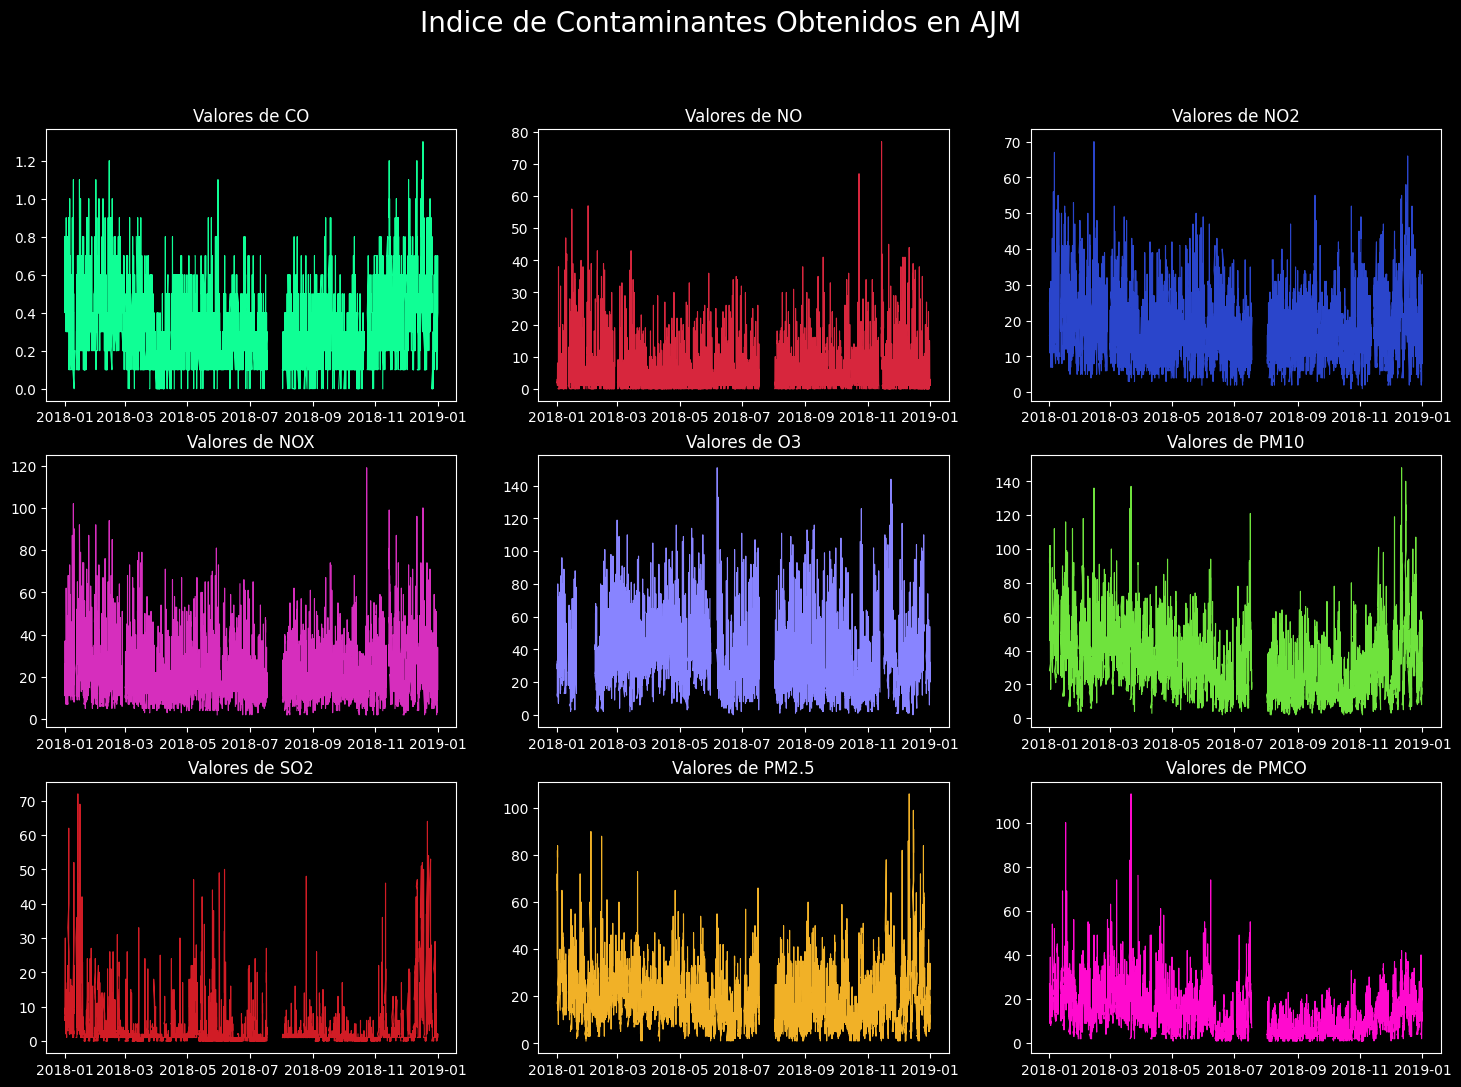

In [6]:
# SE GRAFICAN LOS RESULTADOS
plt.figure(figsize=(18,12))
plt.suptitle(f'Indice de Contaminantes Obtenidos en {estacionMAX}', fontsize=20)

for idx, contaminante in enumerate(tb_ajusco.columns):
    plt.subplot(3, 3, idx+1)
    plt.plot(tb_ajusco.index, tb_ajusco[contaminante], linewidth=0.8, color=colores[idx])
    plt.title(f'Valores de {contaminante}')
plt.show()

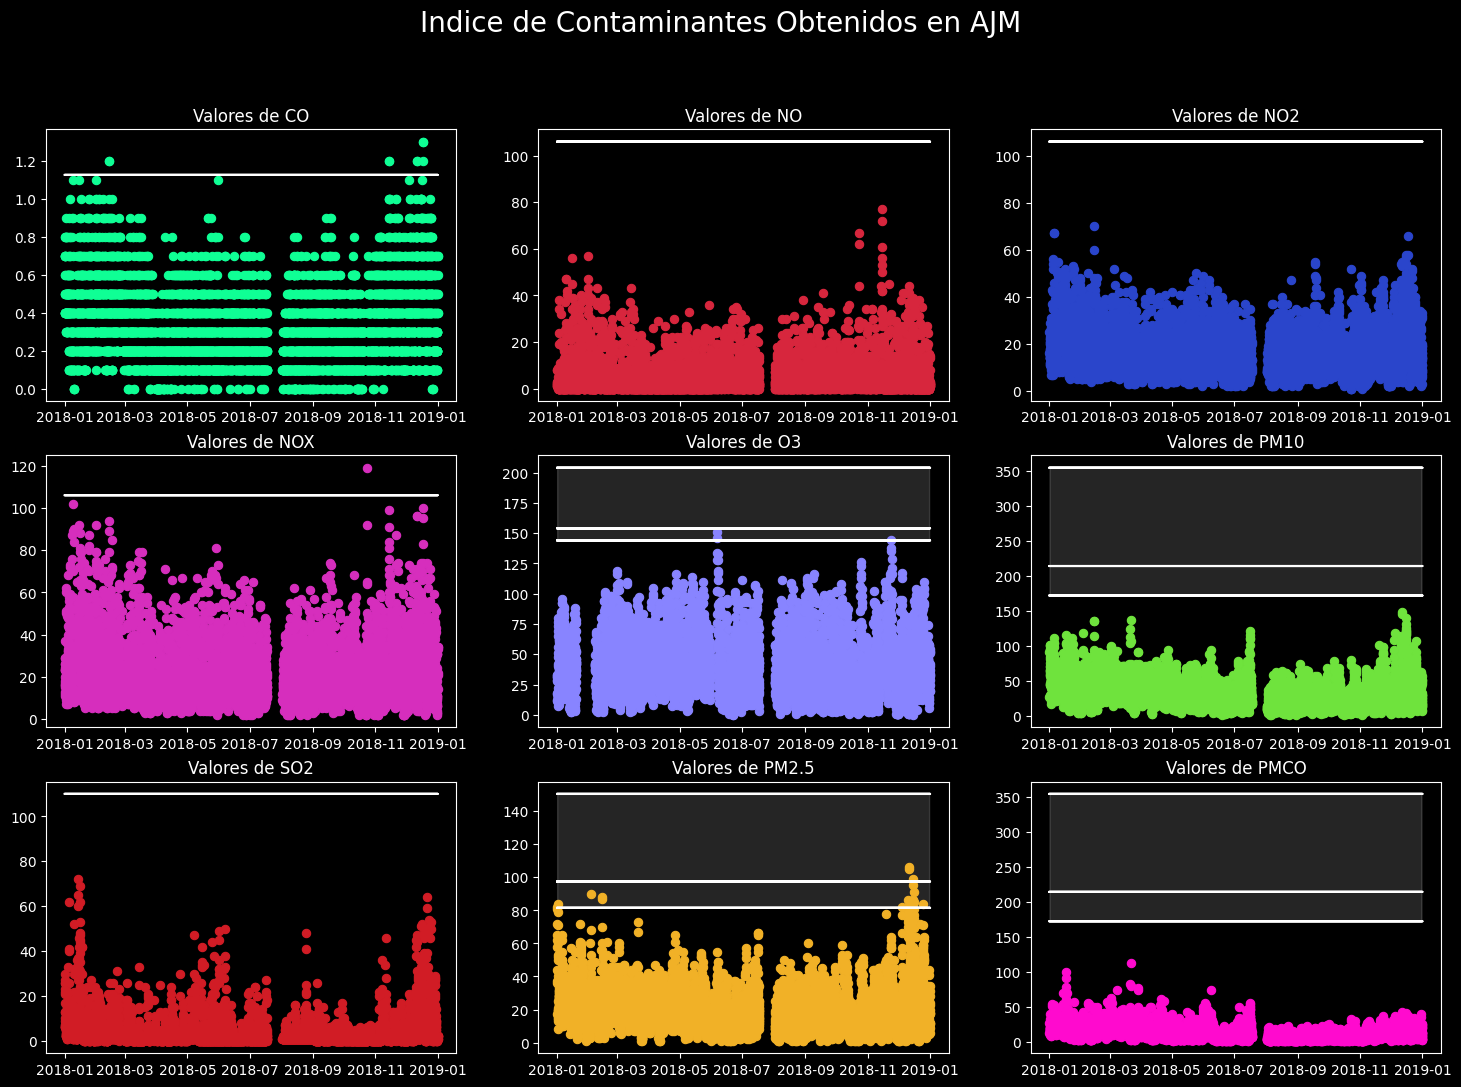

In [7]:
#C0, N0, N02, N0X, 03, PM10, SO2, PM2.5, PMCO
contingencias = [[1.125],[106],[106],[106],[144,154,204],[172,214,354],[110],[81.5,97.4,150.4],[172,214,354]]

# SE GRAFICAN LOS RESULTADOS
plt.figure(figsize=(18,12))
plt.suptitle(f'Indice de Contaminantes Obtenidos en {estacionMAX}', fontsize=20)

for idx, contaminante in enumerate(tb_ajusco.columns):
    plt.subplot(3, 3, idx+1)
    #for j in contingencias[idx]:
    if len(contingencias[idx]) > 1:
        #print(contingencias[idx][0])
        plt.fill_between(tb_ajusco.index,
                np.ones(8760)*contingencias[idx][0],
                np.ones(8760)*contingencias[idx][2],
                color="white", alpha=0.15)
        plt.plot(tb_ajusco.index,np.ones(8760)*contingencias[idx][0], c = 'white')
        plt.plot(tb_ajusco.index,np.ones(8760)*contingencias[idx][1], c = 'white')
        plt.plot(tb_ajusco.index,np.ones(8760)*contingencias[idx][2], c = 'white')
    else:
        plt.plot(tb_ajusco.index,np.ones(8760)*contingencias[idx][0], c = 'white')
    plt.scatter(tb_ajusco.index, tb_ajusco[contaminante], linewidths=0.8, color=colores[idx])
    plt.title(f'Valores de {contaminante}')

plt.show()

# <a id='toc6_'></a>[Creación del dataframe tb_ , donde operamos para hacer los modelos de Predicción](#toc0_)

In [8]:
c_semarnat = [4,5,7]
p_cont = [[1]*6]*len(ls_estaciones)

tb_ = pd.DataFrame()
estaciones_importantes = ["PED","UAX","CCA","BJU",'AJM']
contaminates_importantes = ['O3','PM10','PM2.5']
for est in estaciones_importantes:
    for idx, date in enumerate(db_contaminantes['pollutionMeasurements']['date']):
        for jdx, contaminante in enumerate(contaminates_importantes):  
            if est in db_contaminantes['pollutionMeasurements']['date'][date][contaminante].keys():
                if len(db_contaminantes['pollutionMeasurements']['date'][date][contaminante])==0:
                    tb_[ f"{contaminante}_{est}"] = pd.NA
                else:
                    valorCNT = db_contaminantes['pollutionMeasurements']['date'][date][contaminante][est]
                    tb_.loc[idx, f"{contaminante}_{est}"] = valorCNT
            else:
                tb_[f"{contaminante}_{est}"] = pd.NA
cols = tb_.columns


#Si un elemnto de tb es igual a una cadena vacía, se remplaza con NA de pandas

tb_ = np.where(tb_=='',pd.NA,tb_) 


tb_[~pd.isna(tb_)] = tb_[~pd.isna(tb_)].astype(dtype='float') # elementos de tb que NO son valores faltantes se remplazan por  
tb_ = pd.DataFrame(tb_,columns=cols)
# pm10_desfazado = np.array(tb_['PM10_BJU'][1:],np.nanmean(tb_['PM10_BJU'][1:]))
tb_=tb_.drop(['PM10_PED','PM2.5_PED','PM10_CCA','PM10_UAX'],axis=1)

media = tb_.mean(axis=0,skipna=True)[6]
pm10_desfazado = np.array(tb_['PM10_BJU'][1:])
pm10_desfazado =np.append(pm10_desfazado,media)
media = tb_.mean(axis=0,skipna=True)[10]
pm2_5_desfazado = np.array(tb_['PM2.5_BJU'][1:])
pm2_5_desfazado =np.append(pm2_5_desfazado,media)

## NOTA_ Probar modelo con esto puesto en desfazado, o directamente quitando las columnas
tb_['PM10_PED'] = pm10_desfazado
tb_['PM10_CCA'] = pm10_desfazado
tb_['PM10_UAX'] = pm10_desfazado
tb_['PM2.5_PED'] = pm2_5_desfazado

#NO CORRER cuando ya has corrido todo. Esto es debido a que por que ya no hay nans, se genera un bug.

cords = [[],[],[]]
ant = pd.isna(tb_[tb_.columns[0]][0])
a = 0
for i,col in enumerate(tb_.columns):
    for ind in range(0,8759):
        if pd.isna(tb_[col][ind]) and pd.isna(tb_[col][ind+1]):
            cords[0].append(i)
            cords[1].append(ind)
            cords[2].append(i)
            a = 1
        elif a==1:
            cords[0].append(col)
            cords[1].append(ind)
            cords[2].append(i)
            a=0
cord_mean = [1]*2
ant = 0
for num,i in enumerate(cords[0]):
    if type(i) == str:
        aux = num
        if aux-ant >6:
            for i in range(ant,aux):
                #cord_mean[0].append(cords[2][num])
                cord_mean[0] = np.append(cord_mean[0],cords[2][num])
                #cord_mean[1].append(cords[1][num])
                cord_mean[1] = np.append(cord_mean[1],cords[1][num])
        ant = aux
means = tb_.mean(axis=0)
indexes = means.index
for i,j in zip(cord_mean[0],cord_mean[1]):
    tb_[indexes[i]][j] = means[i]

from scipy.interpolate import griddata

for i,aux in enumerate(tb_):
       a = ~pd.isna(tb_[aux])
       cord_nonnan = np.argwhere(np.array(a))
       val = np.array(tb_[aux][a])
       b = pd.isna(tb_[aux])
       c_nan = np.argwhere(np.array(b))
       tb_[aux][b] =griddata(cord_nonnan,val,c_nan,method = 'nearest')

         
nivel_de_c = 40
p_cont = []*3
contingencias = [[144-nivel_de_c,144,154],[172-nivel_de_c,172,214],[81.5-nivel_de_c,81.5,97.4]]
for i,col in enumerate(['O3_AJM','PM10_AJM','PM2.5_AJM']):
     p_cont.append(tb_[col] >= contingencias[i][1])
tb_['Cont_AJM']  = False
  
aux = 0
for i,j,k in zip(p_cont[0],p_cont[1],p_cont[2]):
    if i or j or k:
        tb_['Cont_AJM'][aux] =True
    aux+=1

tb_

C:\Users\IKER\AppData\Local\Temp\ipykernel_10428\2972071361.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tb_['Cont_AJM'][aux] =True


,O3_PED,O3_UAX,PM2.5_UAX,O3_CCA,PM2.5_CCA,O3_BJU,PM10_BJU,PM2.5_BJU,O3_AJM,PM10_AJM,PM2.5_AJM,PM10_PED,PM10_CCA,PM10_UAX,PM2.5_PED,Cont_AJM
0,19.0,31.47272,112.0,32.005739,80.0,22.0,78.0,56.0,31.0,92.0,65.0,73.0,73.0,73.0,55.0,False
1,23.0,31.47272,91.0,32.005739,77.0,27.0,73.0,55.0,28.0,95.0,72.0,82.0,82.0,82.0,66.0,False
2,27.0,31.47272,59.0,32.005739,67.0,23.0,82.0,66.0,29.0,81.0,62.0,87.0,87.0,87.0,72.0,False
3,30.0,31.47272,66.0,32.005739,60.0,21.0,87.0,72.0,33.0,59.0,44.0,69.0,69.0,69.0,56.0,False
4,22.0,31.47272,82.0,32.005739,57.0,17.0,69.0,56.0,33.0,48.0,37.0,62.0,62.0,62.0,52.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,25.0,12.0,32.0,26.0,26.0,7.0,35.0,14.0,33.0,52.0,31.0,39.0,39.0,39.0,22.0,False
8756,15.0,16.0,34.0,6.0,37.0,8.0,39.0,22.0,20.0,58.0,34.0,56.0,56.0,56.0,37.0,False
8757,12.0,13.0,39.0,4.0,31.0,10.0,56.0,37.0,25.0,49.0,24.0,67.0,67.0,67.0,46.0,False
8758,18.0,7.0,38.0,4.0,39.0,3.0,67.0,46.0,32.0,46.0,23.0,64.0,64.0,64.0,47.0,False


# <a id='toc7_'></a>[Comparación de Gráficas de los Contaminantes](#toc0_)

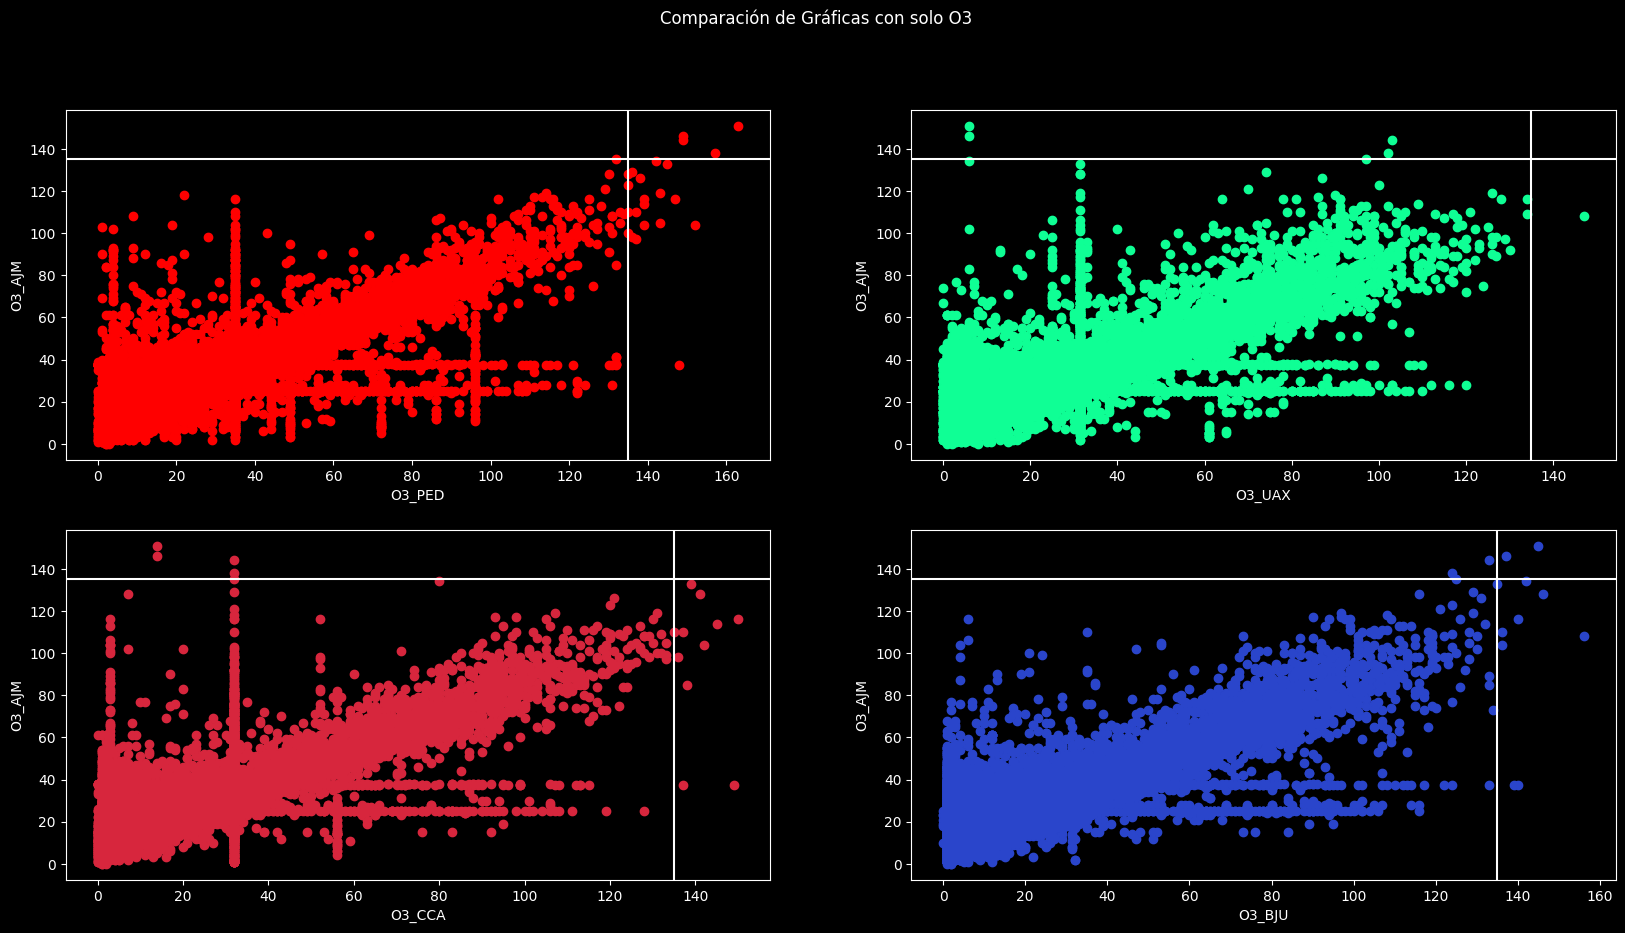

In [24]:
plt.style.use('dark_background')

# GRAFICAS COMPARATIVAS PARA 03

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.scatter(tb_["O3_PED"], tb_["O3_AJM"], color = "red")
plt.xlabel("O3_PED")
plt.ylabel("O3_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 2)
plt.scatter(tb_["O3_UAX"], tb_["O3_AJM"], color=colores[0])
plt.xlabel("O3_UAX")
plt.ylabel("O3_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 3)
plt.scatter(tb_["O3_CCA"], tb_["O3_AJM"], color=colores[1])
plt.xlabel("O3_CCA")
plt.ylabel("O3_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 4)
plt.scatter(tb_["O3_BJU"], tb_["O3_AJM"], color=colores[2])
plt.xlabel("O3_BJU")
plt.ylabel("O3_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.suptitle("Comparación de Gráficas con solo O3")
plt.show()

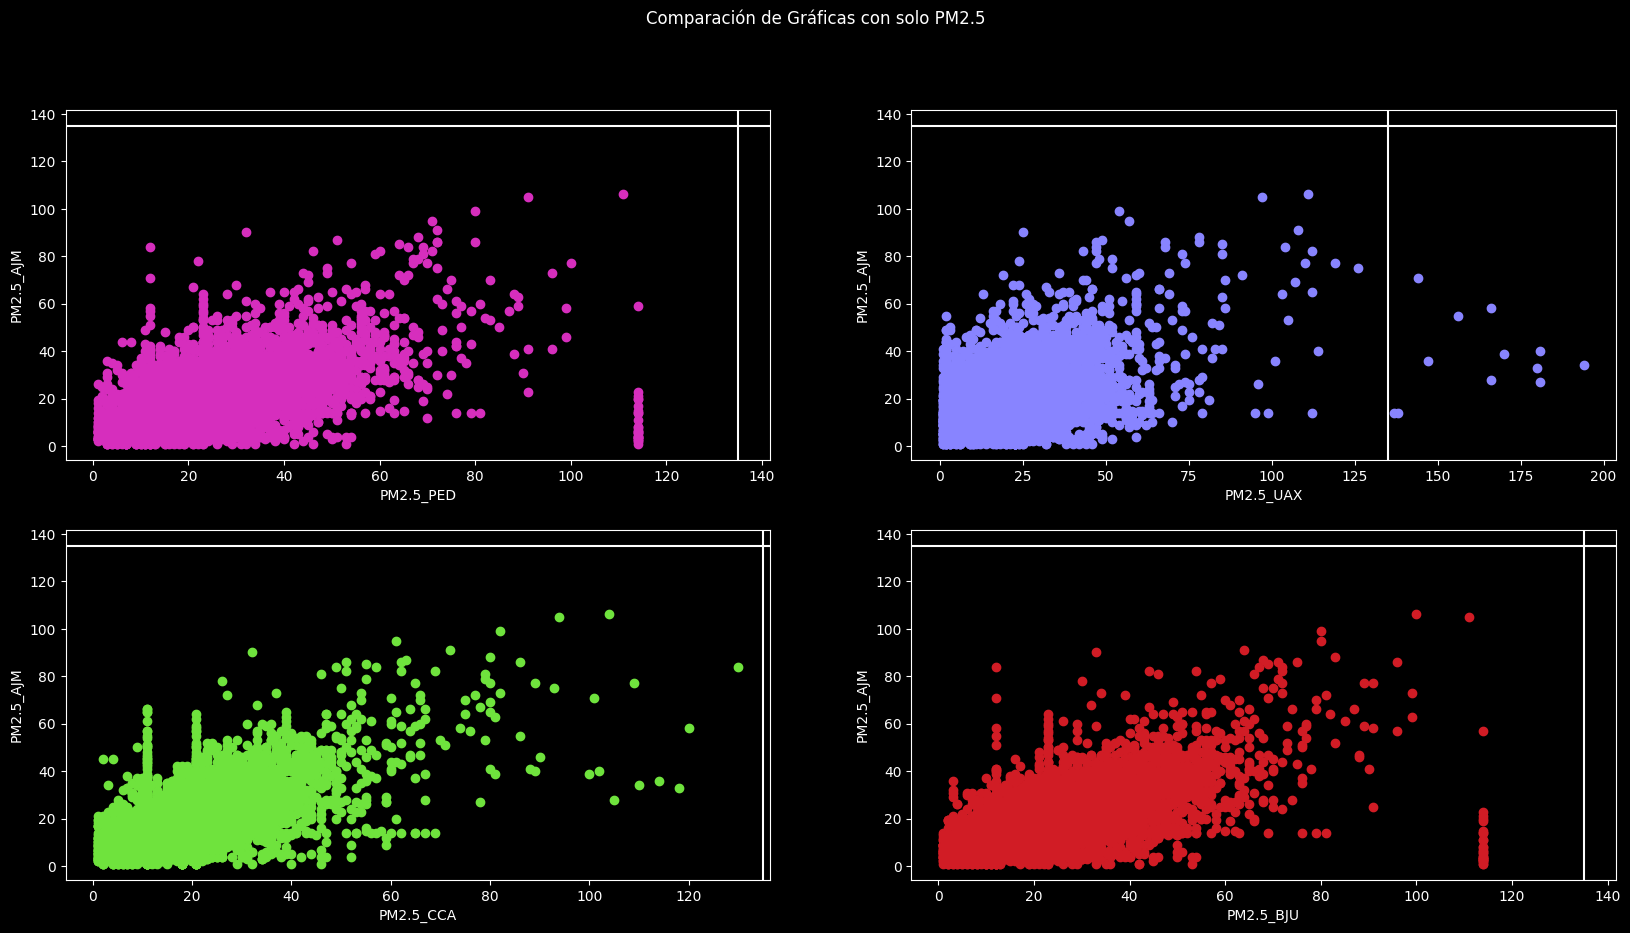

In [25]:
# GRAFICAS COMPARATIVAS PARA PM2.5

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.scatter(tb_["PM2.5_PED"], tb_["PM2.5_AJM"], color=colores[3])
plt.xlabel("PM2.5_PED")
plt.ylabel("PM2.5_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 2)
plt.scatter(tb_["PM2.5_UAX"], tb_["PM2.5_AJM"], color=colores[4])
plt.xlabel("PM2.5_UAX")
plt.ylabel("PM2.5_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 3)
plt.scatter(tb_["PM2.5_CCA"], tb_["PM2.5_AJM"], color=colores[5])
plt.xlabel("PM2.5_CCA")
plt.ylabel("PM2.5_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 4)
plt.scatter(tb_["PM2.5_BJU"], tb_["PM2.5_AJM"], color=colores[6])
plt.xlabel("PM2.5_BJU")
plt.ylabel("PM2.5_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.suptitle("Comparación de Gráficas con solo PM2.5")
plt.show()

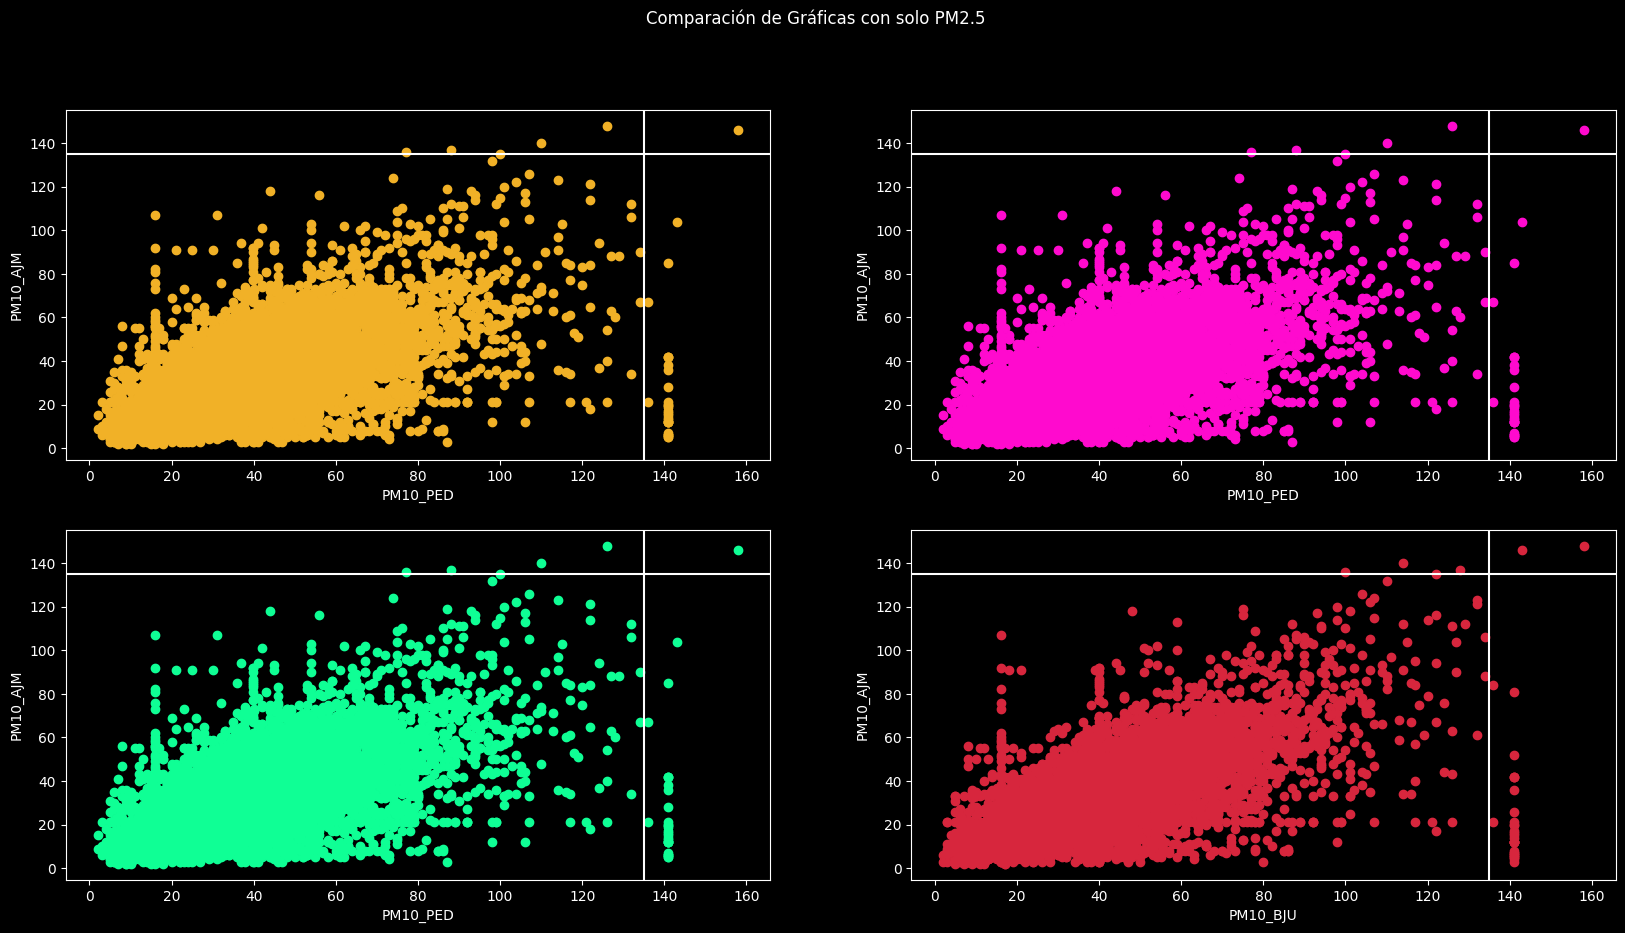

In [26]:

# GRAFICAS COMPARATIVAS PARA PM10
plt.figure(figsize = (20, 10))

plt.subplot(2, 2, 1)
plt.scatter(tb_["PM10_PED"], tb_["PM10_AJM"], color=colores[7])
plt.xlabel("PM10_PED")
plt.ylabel("PM10_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 2)
plt.scatter(tb_["PM10_UAX"], tb_["PM10_AJM"], color=colores[8])
plt.xlabel("PM10_PED")
plt.ylabel("PM10_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 3)
plt.scatter(tb_["PM10_CCA"], tb_["PM10_AJM"], color=colores[0])
plt.xlabel("PM10_PED")
plt.ylabel("PM10_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.subplot(2, 2, 4)
plt.scatter(tb_["PM10_BJU"], tb_["PM10_AJM"], color=colores[1])
plt.xlabel("PM10_BJU")
plt.ylabel("PM10_AJM")
plt.axhline(y=135, color='w')
plt.axvline(x=135, color='w')

plt.suptitle("Comparación de Gráficas con solo PM2.5")
plt.show()

# <a id='toc8_'></a>[Empiezo con el Modelo de Support Vector Machine](#toc0_)

Accuracy: 0.9969558599695586


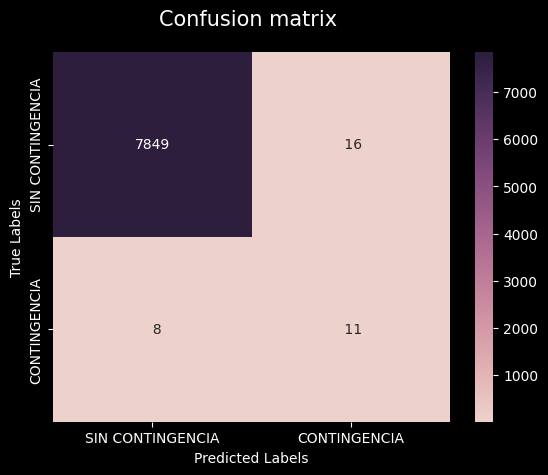

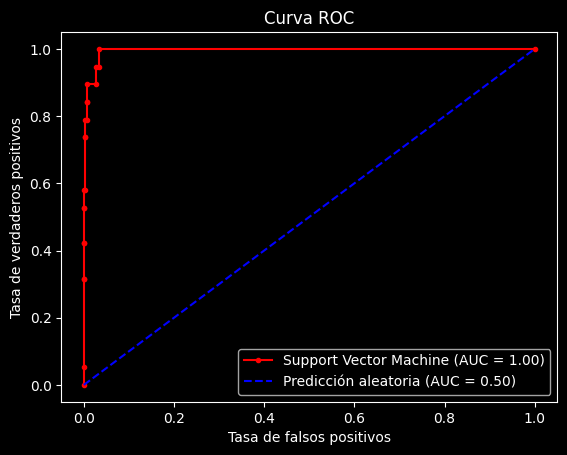

In [11]:
# Código de Support Vector Machine

# creo variables con las que haré el SVC

x = tb_.drop("Cont_AJM", axis = 1)
y = tb_["Cont_AJM"]

# Hago el entrenamiento

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.9)

# Hago el SVC con un kernel lineal
svclassifier = SVC(kernel = "linear",probability=True)
svclassifier.fit(x_train, y_train)

# Hago la predicción

y_pred = svclassifier.predict(x_test)
print("Accuracy:", metrics.accuracy_score (y_test, y_pred))
svm_scores = svclassifier.decision_function(x_test)

# Código de la Matriz de Confusión

class_names = ['SIN CONTINGENCIA','CONTINGENCIA']

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='3.0f', xticklabels=class_names,
            yticklabels=class_names, cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix ', y=1.05, size=15)
plt.show()

# Código de la Curva ROC

# Calcular el AUC
svm_auc = roc_auc_score(y_test, svm_scores)


# Calcular el AUC para la predicción aleatoria
random_auc = roc_auc_score(y_test, [0] * len(y_test))  # Predicción aleatoria siempre es 0


# Calcular la tasa de falsos positivos y la tasa de verdaderos positivos
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)


# Calcular la tasa de falsos positivos y la tasa de verdaderos positivos para la predicción aleatoria
random_fpr, random_tpr, _ = roc_curve(y_test, [0] * len(y_test))  # Predicción aleatoria siempre es 0


# Graficar la curva ROC para el clasificador SVM
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machine (AUC = %0.2f)' % svm_auc,color="red")

# Graficar la curva ROC para la predicción aleatoria
plt.plot(random_fpr, random_tpr, linestyle='--', label='Predicción aleatoria (AUC = %0.2f)' % random_auc,color="blue")
plt.title('Curva ROC')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend()
plt.show()



In [12]:


# Código de la Curva de Aprendizaje

x = tb_.drop("Cont_AJM", axis = 1)
y = tb_["Cont_AJM"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.9)
svclassifier = SVC(kernel = "linear",probability=True)
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
print("Accuracy:", metrics.accuracy_score (y_test, y_pred))

start_time = time.time()

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(svclassifier,x,y,cv=50,scoring='accuracy',n_jobs=-1,
train_sizes=np.linspace(0.01, 1.0, 50))
print('---elapsed time = %s seconds ---' % (time.time()- start_time))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Media y standard deviation
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lineas
plt.plot(train_sizes, train_mean, '--', color='r',  label="Puntaje de aprendizaje")
plt.plot(train_sizes, test_mean, color='b', label="Cross-validation score")

# Bandas
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 color="r", alpha =0.15)

plt.fill_between(train_sizes,
                 test_mean - test_std,
                 test_mean + test_std,
                 color="b", alpha = 0.15)

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Puntaje de accuracy"), plt.legend(loc="right")
plt.grid(True)
plt.show()

Accuracy: 0.9975900558092339


c:\Users\IKER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 21 members, which is less than n_splits=50.
  warnings.warn(


KeyboardInterrupt: 

# <a id='toc9_'></a>[Usamos GridSearch para optimizar los hiperparámetros y ver si mejora nuestro modelo](#toc0_)

In [ ]:
# creamos un nuevo dataframe llamado tb_quasicon

dt = SVC()
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=1)

x = tb_.drop("Cont_AJM", axis = 1)
y = tb_["Cont_AJM"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

grid_param = dict()
grid_param['C'] = np.linspace(0,1,10)
grid_param['kernel'] = ['linear','poly', 'rbf','sigmoid']
grid_param['gamma'] = ['scale','auto']
grid_param['break_ties'] = [True] 
grid_param['probability'] = [True]

search = GridSearchCV(dt, grid_param, scoring='accuracy', n_jobs=-1, cv=cv)
result = search.fit(x_train, y_train)
print('Best Hyperparameters: %s' % result.best_params_)

y_pred = search.predict(x_test)
print("Accuracy:", metrics.accuracy_score (y_test, y_pred))

# Obtener las distancias firmadas desde el hiperplano de separación (estimación de la probabilidad)
svm_scores = search.decision_function(x_test)

# Matriz de Confusión

class_names = ['SIN CONTINGENCIA','CONTINGENCIA']

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='3.0f', xticklabels=class_names,
            yticklabels=class_names, cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix ', y=1.05, size=15)
plt.show()

# Curva ROC

# Calcular el AUC
svm_auc = roc_auc_score(y_test, svm_scores)

# Calcular el AUC para la predicción aleatoria
random_auc = roc_auc_score(y_test, [0] * len(y_test))  # Predicción aleatoria siempre es 0

# Calcular la tasa de falsos positivos y la tasa de verdaderos positivos
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)

# Calcular la tasa de falsos positivos y la tasa de verdaderos positivos para la predicción aleatoria
random_fpr, random_tpr, _ = roc_curve(y_test, [0] * len(y_test))  # Predicción aleatoria siempre es 0

# Graficar la curva ROC para el clasificador SVM
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machine (AUC = %0.2f)' % svm_auc,color="red")

# Graficar la curva ROC para la predicción aleatoria
plt.plot(random_fpr, random_tpr, linestyle='--', label='Predicción aleatoria (AUC = %0.2f)' % random_auc,color="blue")

# Agregar etiquetas y leyenda al gráfico
plt.title('Curva ROC')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend()

# Mostrar el gráfico
plt.show()

start_time = time.time()

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(search,x[30:],y[30:],scoring='accuracy',n_jobs=-1,
train_sizes=np.linspace(0.01, 1.0, 30))
print('---elapsed time = %s seconds ---' % (time.time()- start_time))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Media y standard deviation
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lineas
plt.plot(train_sizes, train_mean, '--', color='r',  label="Puntaje de aprendizaje")
plt.plot(train_sizes, test_mean, color='b', label="Cross-validation score")

# Bandas
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 color="r", alpha =0.15)

plt.fill_between(train_sizes,
                 test_mean - test_std,
                 test_mean + test_std,
                 color="b", alpha = 0.15)

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Puntaje de accuracy"), plt.legend(loc="right")
plt.grid(True)
plt.ylim(0,1.1)
plt.show()


NameError: name 'RepeatedStratifiedKFold' is not defined

# <a id='toc10_'></a>[Creamos otro modelo llamado Red Neuronal para ver cuál es mejor para nuestros datos](#toc0_)

In [ ]:
x = tb_.drop("Cont_AJM", axis = 1)
y = tb_["Cont_AJM"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

model = Sequential([Flatten()])
model.add(Dense(64, input_dim=15))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

# COMPILAR EL MODELO
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# ENTRENAMIENTO DEL MODELO
history = model.fit(x_train, y_train, batch_size=256,
                    epochs=50, verbose=1,
                    validation_data=(x_test, y_test))

# EVALUAR EL MODELO
score = model.evaluate(x_test, y_test, verbose=1)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# SE GRAFICA LA CURVA DE APRENDIZAJE
plt.plot(history.history['loss'], color='b')
plt.title('MLP Loss')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.xlabel('Epoch')
plt.show()


# SE GRAFICA LA CURVA DE ENTRENAMIENTO JUNTO CON LA DE VALIDACION
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Training and Validation loss')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


NameError: name 'Sequential' is not defined